In [1]:
# Automatically update modifications in Functions
%load_ext autoreload
%autoreload 2

In [2]:
import os

work_dir = "./"
inputs_dir = "./Inputs/"
outputs_dir = "./Outputs/"

os.chdir(work_dir)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from Functions.utils import add_calendar

from datetime import datetime

## Formatting df_load_curve

In [4]:
# Processing French energy consumption (https://www.rte-france.com/eco2mix/telecharger-les-indicateurs)

df_load_curve_2018 = pd.read_csv(inputs_dir + "eCO2mix_RTE_Annuel-Definitif_2018.csv", sep=";", usecols=['Date', 'Heures', 'Consommation'],
                                 encoding='latin-1')
df_load_curve_2019 = pd.read_csv(inputs_dir + "Donnees_RTE_Annuel.txt", sep=";", usecols=['Date', 'Heures', 'Consommation'])

df_load_curve = pd.concat([df_load_curve_2018, df_load_curve_2019], ignore_index=True)

df_load_curve = df_load_curve.rename(columns={'Date':'date', 'Heures':'hour_min', 'Consommation':'value'})

df_load_curve["horodate"] = df_load_curve["date"] + " " + df_load_curve["hour_min"]
df_load_curve["horodate"]  = pd.to_datetime(df_load_curve["horodate"], format='%d/%m/%Y %H:%M' )

#df_load_curve['horodate'] = df_load_curve['horodate'].dt.tz_localize('Europe/Paris', ambiguous=True, nonexistent='infer')#.dt.tz_convert('Europe/Paris')

df_load_curve['horodate'] = df_load_curve['horodate'].dt.tz_localize('utc').dt.tz_convert('Europe/Paris')

df_load_curve = df_load_curve.dropna().reset_index(drop=True)
df_load_curve = df_load_curve.drop(columns=['date', 'hour_min'])
df_load_curve = df_load_curve[['horodate', 'value']]

df_load_curve = add_calendar(df_load_curve)
print(df_load_curve.shape)

df_load_curve.head()

(35040, 9)


,horodate,value,date,month,weekday,hour,min,is_gap_day,is_open_day
0,2018-01-01 01:00:00+01:00,61127.0,2018-01-01 00:00:00+01:00,1,0,1,0,1,0
1,2018-01-01 01:30:00+01:00,59962.0,2018-01-01 00:00:00+01:00,1,0,1,30,1,0
2,2018-01-01 02:00:00+01:00,57879.0,2018-01-01 00:00:00+01:00,1,0,2,0,1,0
3,2018-01-01 02:30:00+01:00,57901.0,2018-01-01 00:00:00+01:00,1,0,2,30,1,0
4,2018-01-01 03:00:00+01:00,57261.0,2018-01-01 00:00:00+01:00,1,0,3,0,1,0


## Sanity check df_load_curve

Doing a sanity check to check for :

- Period covered
- Missing values
- Descriptive statistics for consumption and abnormal values

In [5]:
# Period used for metrics calculation
print(np.min(df_load_curve['horodate']), np.max(df_load_curve['horodate']))

2018-01-01 01:00:00+01:00 2020-01-01 00:30:00+01:00


<Axes: xlabel='date'>

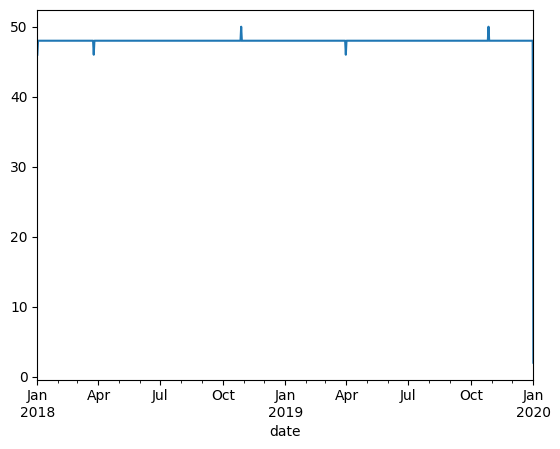

In [6]:
# Number of values per day
df_test = df_load_curve.copy()
df_test = df_test.groupby(['date'])['value'].count()#.reset_index(drop=False)
df_test.plot()

On a des données manquantes 2 fois par an à cause du changement d'heure

In [7]:
# Descriptive statistics for consumption
df_test = df_load_curve.copy()
df_test[['value']].describe(percentiles=[0.25, 0.75, 0.9, 0.95, 0.99])

,value
count,35040.000000
mean,53995.327911
std,11898.034567
min,30475.000000
25%,44988.750000
50%,52323.500000
75%,62202.000000
90%,71141.100000
95%,75694.400000
99%,83548.830000


## EDA df_load_curve

Doing an Exploratory Data Analysis to check for time series properties :

- Temporal autocorrelation
- Seasonnality : month, day of week, hour of day
- Linearity
- Relation between daily consumption and daily temperature ?

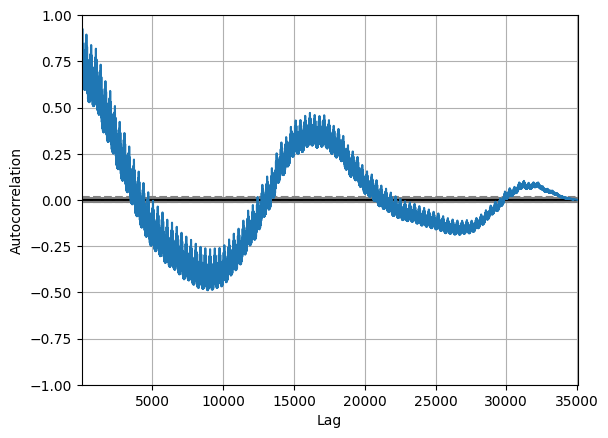

In [8]:
# Temporal autocorrelation

from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_load_curve['value'])
plt.show()


The horizontal lines in the plot correspond to 95% and 99% confidence bands.

The dashed line is 99% confidence band.

<Axes: ylabel='Puissance en W'>

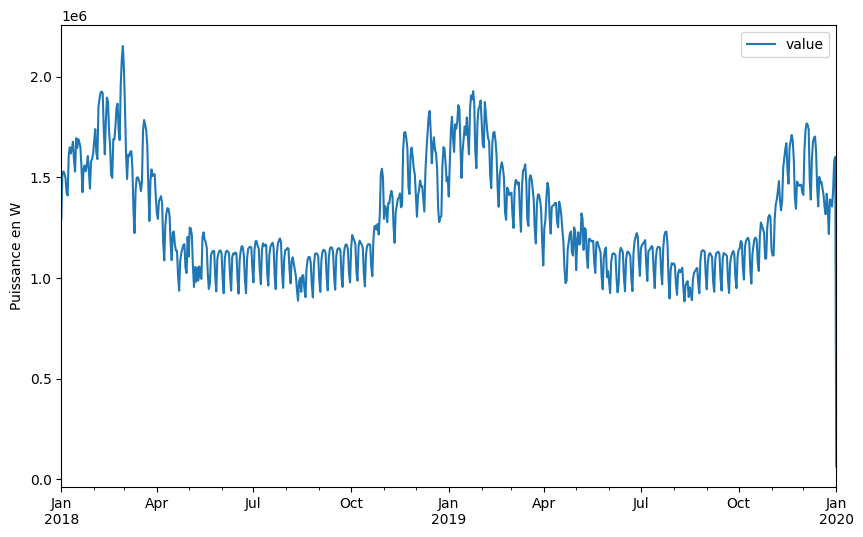

In [9]:
# Daily consumption plot/Linearity
df_plot = df_load_curve.copy()

df_plot = df_plot.groupby(['date'])[['value']].aggregate('sum').reset_index(drop=False)
df_plot['value'] = df_plot['value']/2
df_plot.set_index(['date'])[['value']].plot(figsize=(10,6), legend=True, xlabel='', ylabel='Puissance en W')

<Axes: ylabel='Puissance en W'>

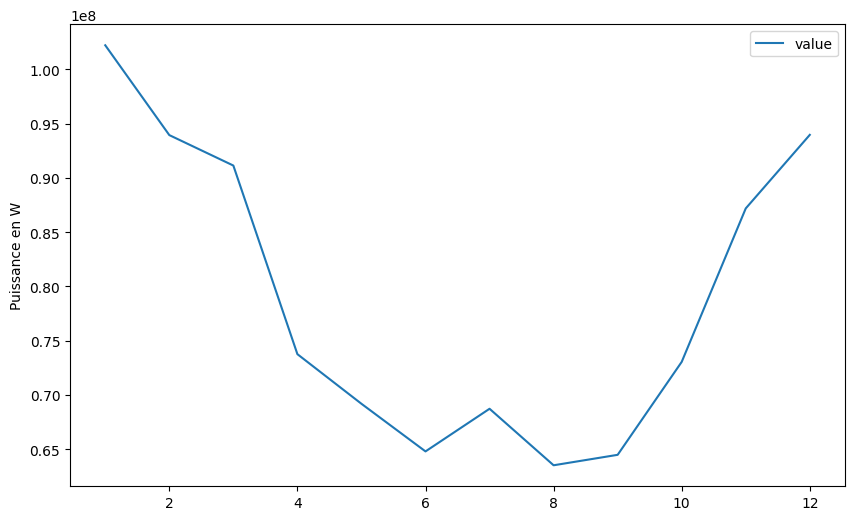

In [10]:
# Mean monthly consumption plot
df_plot = df_load_curve.copy()

df_plot = df_plot.groupby(['month'])[['value']].aggregate('sum').reset_index(drop=False)
df_plot['value'] = df_plot['value']/2
df_plot.set_index(['month'])[['value']].plot(figsize=(10,6), legend=True, xlabel='', ylabel='Puissance en W')

<Axes: ylabel='Puissance en W'>

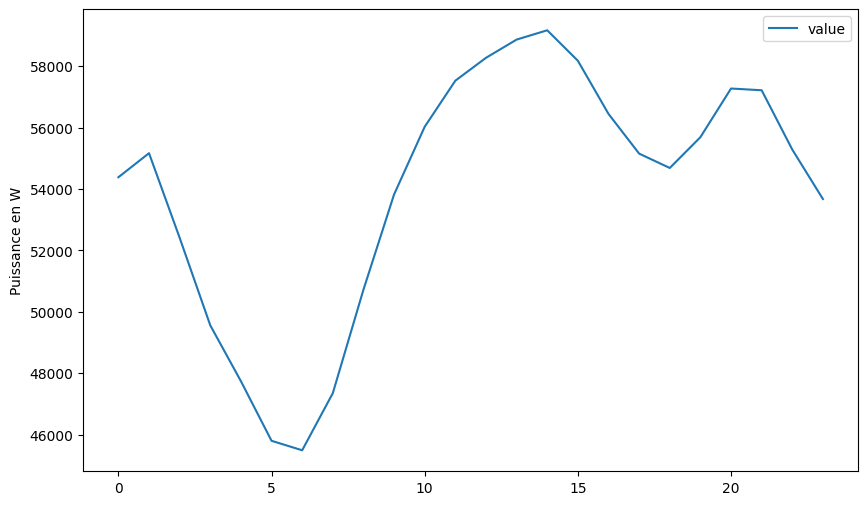

In [11]:
# Mean hourly consumption plot
df_plot = df_load_curve.copy()

df_plot = df_plot.groupby(['hour'])[['value']].aggregate('mean').reset_index(drop=False)
df_plot.set_index(['hour'])[['value']].plot(figsize=(10,6), legend=True, xlabel='', ylabel='Puissance en W')

<Axes: ylabel='Puissance en W'>

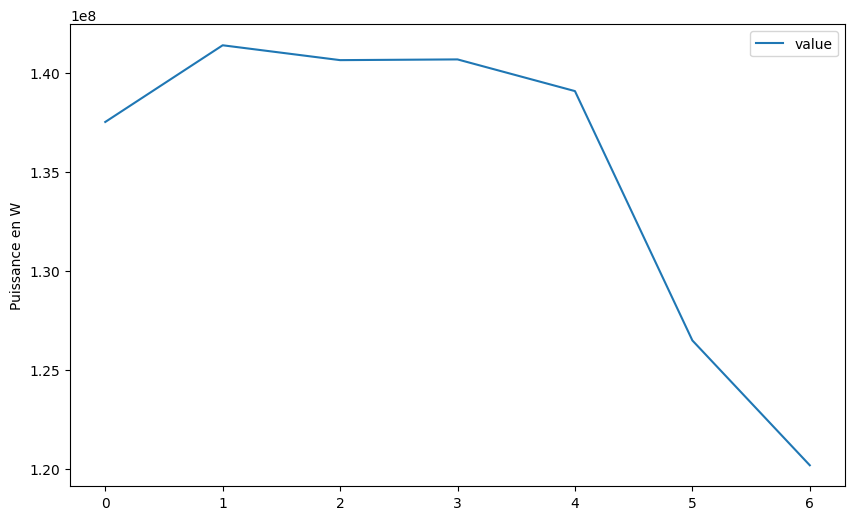

In [12]:
# Mean weekday consumption plot
df_plot = df_load_curve.copy()

df_plot = df_plot.groupby(['weekday'])[['value']].aggregate('sum').reset_index(drop=False)
df_plot['value'] = df_plot['value']/2
df_plot.set_index(['weekday'])[['value']].plot(figsize=(10,6), legend=True, xlabel='', ylabel='Puissance en W')

La consommation énergétique diminue pendant le weekend, ce qui signifie que les gens ne restent pas chez eux.

# Prediction models using endogenous variables

In [13]:
# Defining train/test
df_load_curve['is_train'] = df_load_curve['horodate'].lt(pd.Timestamp(datetime(2019, 12, 25, 0, 0), tz='Europe/Paris')).astype('int')

df_load_curve['is_test'] = 1 - df_load_curve['is_train']

In [14]:
# Statistics models : Median (Baseline)
df_1 = df_load_curve.copy()
median = df_1.loc[df_1['is_train'] == 1, 'value'].median()
df_1.loc[df_1['is_test'] == 1, 'pred'] = median

In [55]:
from sklearn.metrics import mean_absolute_percentage_error as MAPE

print("MAPE of baseline: {:.2f}%".format(100 * MAPE(df_1.loc[df_1['is_test'] == 1, 'value'], df_1.loc[df_1['is_test'] == 1, 'pred'])))

MAPE of baseline: 12.86%


In [15]:
train1=df_load_curve['is_train']
test1=df_load_curve['is_test']

In [16]:
len(train1), len(test1)

(35040, 35040)

In [17]:
train1[train1==1]

0        1
1        1
2        1
3        1
4        1
        ..
34697    1
34698    1
34699    1
34700    1
34701    1
Name: is_train, Length: 34702, dtype: int32

In [18]:
test1[test1==1]

34702    1
34703    1
34704    1
34705    1
34706    1
        ..
35035    1
35036    1
35037    1
35038    1
35039    1
Name: is_test, Length: 338, dtype: int32

In [19]:
N_train=train1[train1==1].shape[0]
N_test=test1[test1==1].shape[0]
print(N_train, N_test)

34702 338


In [20]:
train=df_load_curve[df_load_curve['is_train']==1]["value"]
test=df_load_curve[df_load_curve['is_test']==1]["value"]

In [21]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

Le modèle AutoRegressif:
X_t= somme sur i allant de 1 à lags de alpha_i*X_(t-i) + epsilon_t, avec epsilon_t est l'erreur

In [22]:
# Statistics models : AR
ar_model = AutoReg(train, lags=7).fit() # le modèle utilisera les 7 dernières données de train pour prédire la suivante
print(ar_model.summary())

                            AutoReg Model Results                             
Dep. Variable:                  value   No. Observations:                34702
Model:                     AutoReg(7)   Log Likelihood             -284774.656
Method:               Conditional MLE   S.D. of innovations            888.031
Date:                Thu, 06 Feb 2025   AIC                         569567.312
Time:                        13:50:37   BIC                         569643.402
Sample:                             7   HQIC                        569591.559
                                34702                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        440.5674     22.772     19.346      0.000     395.934     485.201
value.L1       1.7013      0.005    316.920      0.000       1.691       1.712
value.L2      -0.5977      0.011    -56.515      0.0

Key Results in the Summary:

* Coefficients: These are the weights assigned to the lagged values of the time series. They indicate the influence of past values on the current value.
* Standard Errors: These measure the accuracy of the coefficients. Smaller standard errors indicate more precise estimates.
* t-values and p-values: These are used to test the hypothesis that a coefficient is different from zero. A small p-value (typically < 0.05) indicates that the coefficient is significantly different from zero.
* R-squared: This measures the proportion of the variance in the dependent variable that is predictable from the independent variables. Higher values indicate a better fit.
* AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion): These are measures of the model's quality, with lower values indicating a better model.

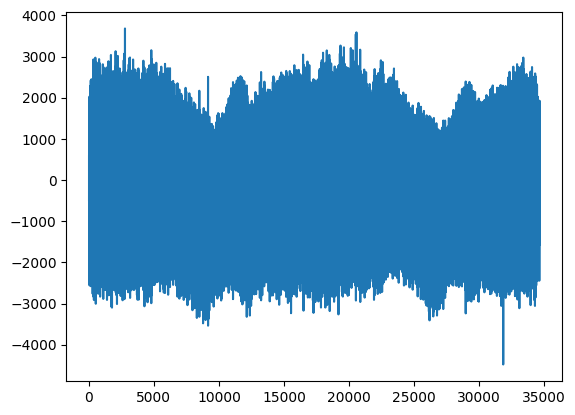

In [23]:
# les résidus du modèle
plt.plot(ar_model.resid)

In [24]:
estim_ar = ar_model.predict(start=0, end=len(train1)//2) 
estim_ar[:20]

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
5              NaN
6              NaN
7     53017.987120
8     52723.334087
9     51362.141223
10    51002.137336
11    50165.122206
12    51136.746659
13    50794.763238
14    51658.493892
15    51068.130443
16    51401.303851
17    51508.009492
18    50948.154019
19    50922.686880
dtype: float64

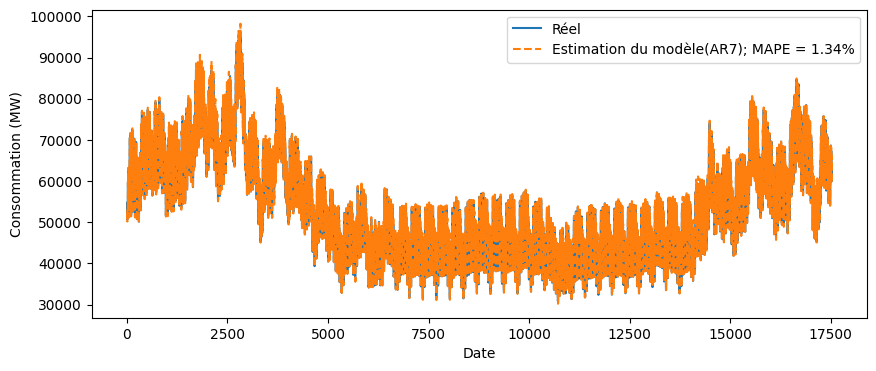

In [25]:
# l'estimation faite par le modèle
estim_ar = estim_ar[~np.isnan(estim_ar)]
train1_aligned = df_load_curve.loc[train1.iloc[6:len(train1)//2].index, 'value']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4), sharex=True)
ax.plot(train1_aligned.index, train1_aligned, label="Réel")
ax.plot(estim_ar, label="Estimation du modèle(AR7); " + "MAPE = " + str(round(100*MAPE(train1_aligned, estim_ar), 2)) + "%", linestyle='--')
ax.set_ylabel('Consommation (MW)')
ax.set_xlabel('Date')
ax.legend()

Le modèle a plutot bien appris l'ensemble de train

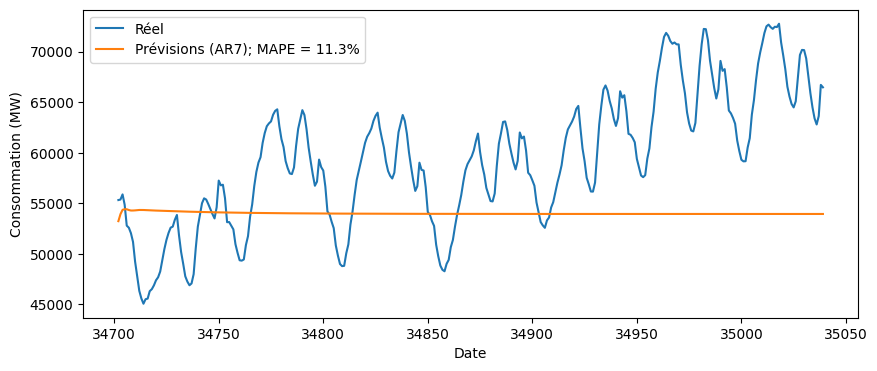

In [26]:
# previsions
pred = ar_model.predict(start=N_train, end=N_train+N_test-1, dynamic=False)
# Plot prevision vs test data
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4), sharex=True)
ax.plot(test.index, test.values[:len(pred)], label="Réel")
ax.plot(test.index, pred, label="Prévisions (AR7); " + "MAPE = " + str(round(100*MAPE(test.values[:len(pred)], pred), 2)) + "%")
ax.set_ylabel('Consommation (MW)')
ax.set_xlabel('Date')
ax.legend()

In [27]:
list_par = [1,2,3,4, 5, 6, 7, 8]
ar_models = [None] *  8
lespred_ar = [None] * 8

for k in range(len(list_par)):
    ar_models[k] = AutoReg(train,lags=k).fit()
    lespred_ar[k] = ar_models[k].predict(start=N_train, end=N_train+N_test-1, dynamic=False)

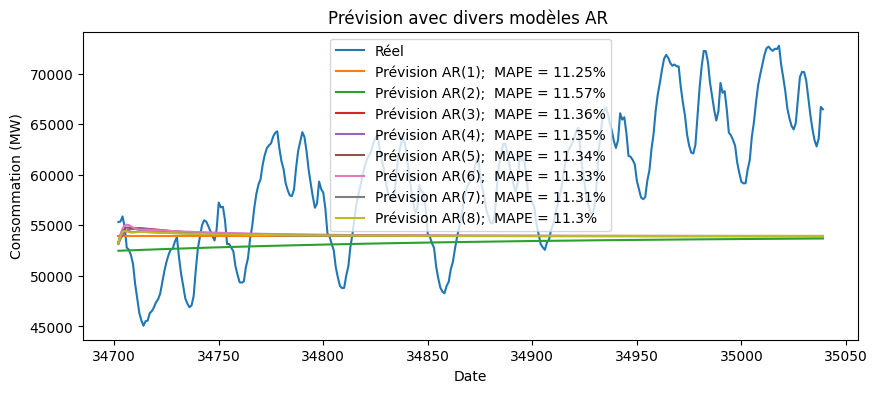

In [28]:
# Plot the prediction vs test data
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4), sharex=True)
ax.plot(test.index, test, label="Réel")
for k in range(len(list_par)):
    ax.plot(test.index, lespred_ar[k], label="Prévision AR(" + str(list_par[k]) + "); " +
            " MAPE = " + str(round(100*MAPE(test, lespred_ar[k]), 2)) + "%")
ax.set_ylabel('Consommation (MW)')
ax.set_xlabel('Date')
ax.set_title("Prévision avec divers modèles AR ")
ax.legend()


Quelque soit le nombre de lags, le modèle AR ne capte pas les variations des données. En effet, vu que la série n'est pas stationnaire, le modèle auto-régressif n'est pas adapté.
Pour comprendre un peu plus l'histoire de la tendance, on va essayer les différentes valeurs proposées par AutoReg

In [29]:
# trend : c=constant, t=time, ct=both, n=none
trends=["n","c","t","ct"]
mape_ar_dict = {}
ar_pred_dict = {}
for trend in trends:
    ar_model = AutoReg(train, lags=7, trend=trend).fit()
    ar_pred = ar_model.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)
    ar_mape = MAPE(test, ar_pred)
    mape_ar_dict[trend] = ar_mape
    ar_pred_dict[trend] = ar_pred

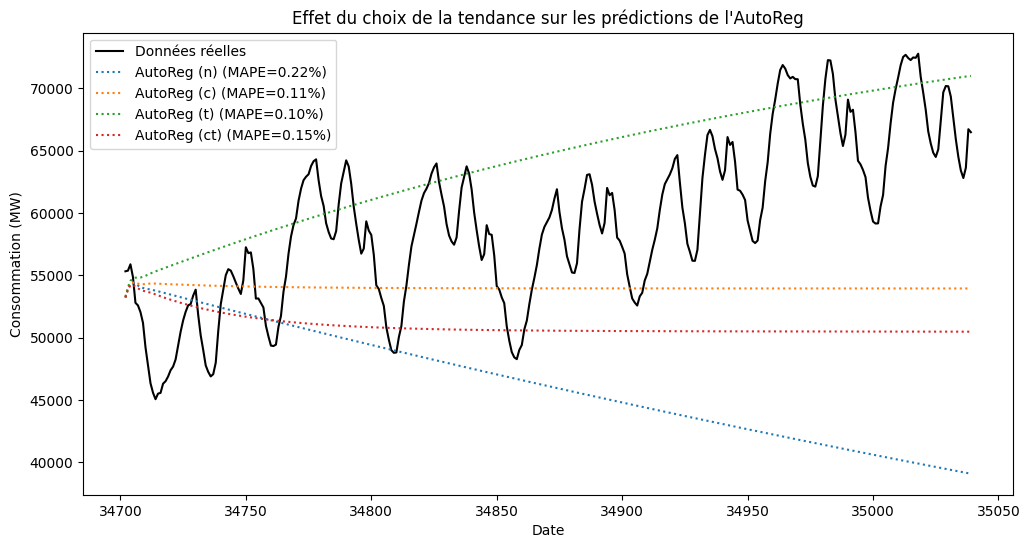

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label="Données réelles", color='black')
for trend in trends:
    plt.plot(test.index, ar_pred_dict[trend], label=f"AutoReg ({trend}) (MAPE={mape_ar_dict[trend]:.2f}%)", linestyle="dotted")
plt.xlabel("Date")
plt.ylabel("Consommation (MW)")
plt.legend()
plt.title("Effet du choix de la tendance sur les prédictions de l'AutoReg")
plt.show()

* Notre série a une tendance temporelle (trend t).
* Le modèle AutoReg ne permet pas de prédire les variations de la consommation, mais sa tendance.
On va regarder maintenant ce qui se passe si on prend en considération la saisonalité.

In [31]:
#  Modèle AutoReg (AR)

# Ensure the train series has a datetime index
train.index = df_load_curve[df_load_curve['is_train'] == 1]['horodate']

# Set the frequency of the time series data
train = train.asfreq(pd.infer_freq(train.index))

ar_model = AutoReg(train, lags=7, trend="n", seasonal=True, period=24).fit()
ar_pred = ar_model.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)
ar_mape = MAPE(test, ar_pred)
print(ar_mape)

0.10256476162364704


In [32]:
periods=[24,7*24,30*24] # daily, weekly, monthly
mape_ar_dict = {}
ar_pred_dict = {}
for period in periods:
    ar_model = AutoReg(train, lags=7, trend="n", seasonal=True, period=period).fit()
    ar_pred = ar_model.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)
    ar_mape = MAPE(test, ar_pred)
    mape_ar_dict[period] = ar_mape
    ar_pred_dict[period] = ar_pred

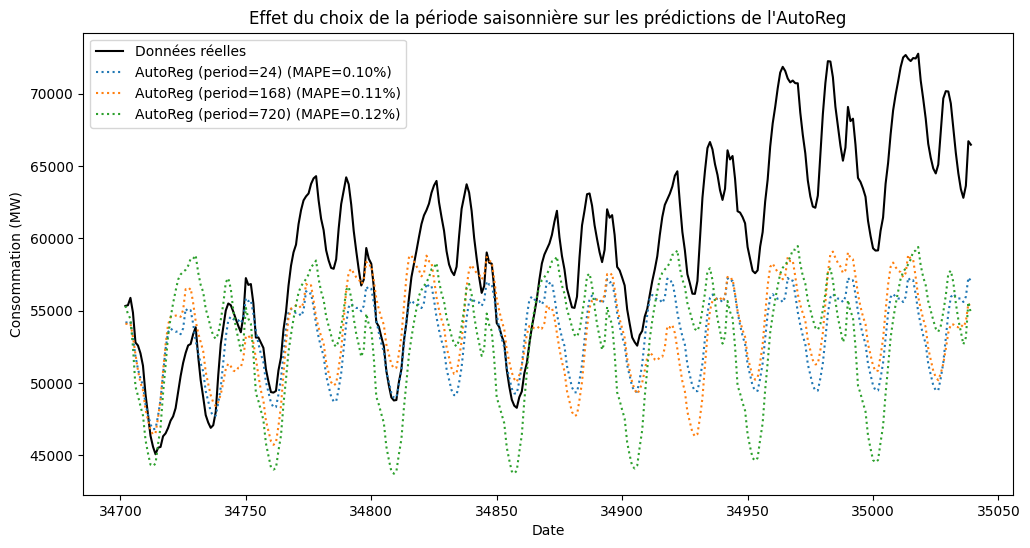

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label="Données réelles", color='black')
for period in periods:
    plt.plot(test.index, ar_pred_dict[period], label=f"AutoReg (period={period}) (MAPE={mape_ar_dict[period]:.2f}%)", linestyle="dotted")
plt.xlabel("Date")
plt.ylabel("Consommation (MW)")
plt.legend()
plt.title("Effet du choix de la période saisonnière sur les prédictions de l'AutoReg")
plt.show()

Quand on a inclu la saisonalité, on a transformé le modèle purement auto-régressif qui prédit une tendance, en un modèle qui suit les variations des données (c'est l'idée de SARIMA). La seasonalité quotidienne semble la plus adaptée.
On va maintenant nous intéresser aux lags.

In [34]:
lags_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
mape_ar_dict = {}
ar_pred_dict = {}
for lag in lags_list:
    ar_model = AutoReg(train, lags=lag, trend="n",seasonal=True, period=24).fit()
    ar_pred = ar_model.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)
    ar_mape = MAPE(test, ar_pred)
    mape_ar_dict[lag] = ar_mape
    ar_pred_dict[lag] = ar_pred

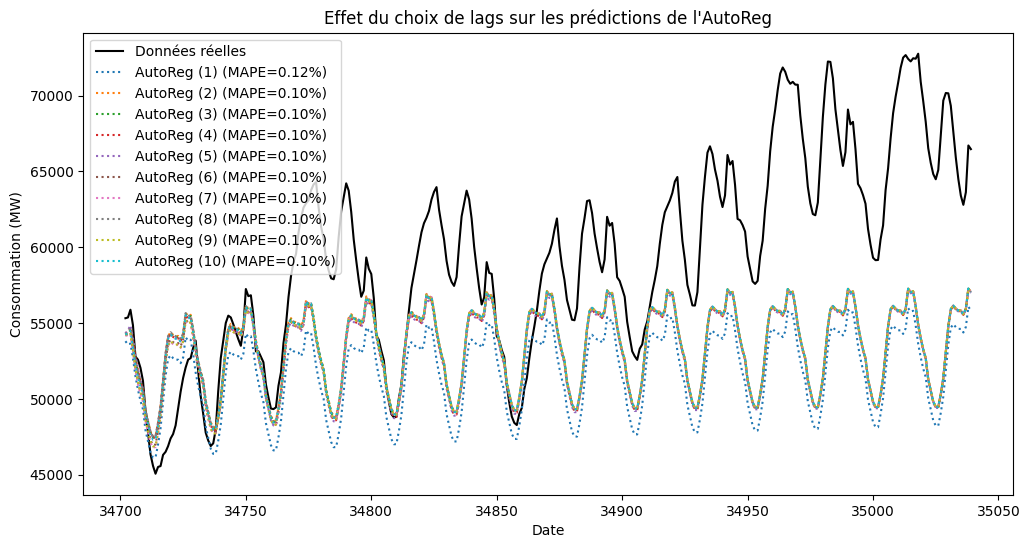

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label="Données réelles", color='black')
for lag in lags_list:
    plt.plot(test.index, ar_pred_dict[lag], label=f"AutoReg ({lag}) (MAPE={mape_ar_dict[lag]:.2f}%)", linestyle="dotted")
plt.xlabel("Date")
plt.ylabel("Consommation (MW)")
plt.legend()
plt.title("Effet du choix de lags sur les prédictions de l'AutoReg")
plt.show()

A partir des 2 valeurs précédentes on arrive à prédire la valeur qui suit. Ceci n'empêche qu'il y a un écart considérable entre les valeurs prédites et les valeurs réelles.

ARIMA (AutoRegressive Integrated Moving Average)
Extension de AR qui gère la tendance avec une différenciation et prend en compte le bruit avec une moyenne mobile.
ARIMA(p,d,q)

p : nombre de termes autorégressifs (AR)

d : nombre de différenciations appliquées pour rendre la série stationnaire. i.e si d=1, on remplace X_t par X_t-X_(t-1).

q : nombre de termes de moyenne mobile (MA)

A utiliser quand :
* La série n’est pas stationnaire, mais elle peut être rendue stationnaire en appliquant une différenciation.
* Il y a une tendance ou une autocorrélation significative.

In [36]:
# Statistical model: ARIMA(p,d,q)
list_par = [2,3,4]
lespred_arima = []

for k in list_par:
    model = ARIMA(train, order=(k, 2, k)).fit()
    prediction = model.predict(start=N_train, end=N_train+N_test-1, dynamic=False)
    lespred_arima.append(prediction)

c:\Users\amiri\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [37]:
lespred_arima

[2019-12-25 00:00:00+01:00    53244.621142
 2019-12-25 00:30:00+01:00    53692.818051
 2019-12-25 01:00:00+01:00    54075.903761
 2019-12-25 01:30:00+01:00    54270.597309
 2019-12-25 02:00:00+01:00    54468.779720
                                  ...     
 2019-12-31 22:30:00+01:00    55247.916370
 2019-12-31 23:00:00+01:00    55249.267960
 2019-12-31 23:30:00+01:00    55250.619550
 2020-01-01 00:00:00+01:00    55251.971139
 2020-01-01 00:30:00+01:00    55253.322729
 Freq: 30min, Name: predicted_mean, Length: 338, dtype: float64,
 2019-12-25 00:00:00+01:00    52957.467993
 2019-12-25 00:30:00+01:00    53235.367926
 2019-12-25 01:00:00+01:00    53575.485386
 2019-12-25 01:30:00+01:00    53821.481096
 2019-12-25 02:00:00+01:00    53859.823419
                                  ...     
 2019-12-31 22:30:00+01:00    52810.363271
 2019-12-31 23:00:00+01:00    52806.414386
 2019-12-31 23:30:00+01:00    52802.465502
 2020-01-01 00:00:00+01:00    52798.516618
 2020-01-01 00:30:00+01:00    52

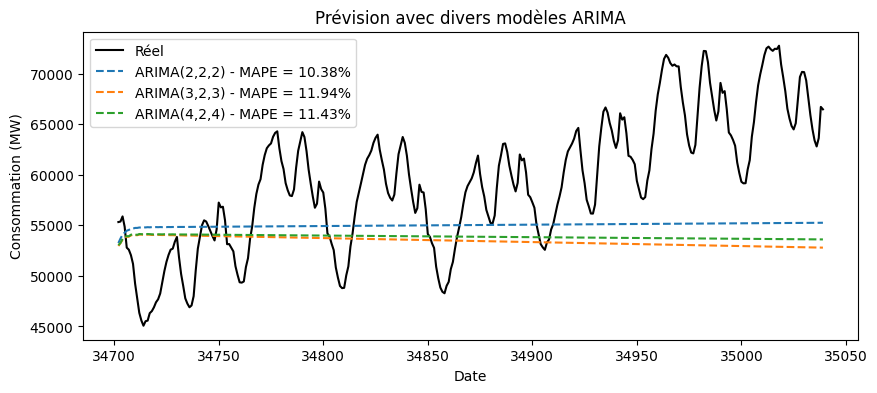

In [38]:
pred_length = len(lespred_arima[0])

#  Visualisation des résultats
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(test.index, test, label="Réel", color="black")

for k, pred in zip(list_par, lespred_arima):
    ax.plot(test.index, pred, label=f"ARIMA({k},2,{k}) - MAPE = {round(100*MAPE(test, pred[:pred_length]),2)}%", linestyle="--")

ax.set_ylabel('Consommation (MW)')
ax.set_xlabel('Date')
ax.set_title("Prévision avec divers modèles ARIMA")
ax.legend()
plt.show()

In [39]:
"""# Define pred_length
pred_length = len(lespred_arima[0])

# Plot the prediction vs test data
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4), sharex=True)
ax.plot(test.index, test, label="Réel")
for k in range(len(list_par)):
    ax.plot(lespred_arima[k], label="Prévision ARIMA(" + str(list_par[k]) + ", 1," +
            str(list_par[k]-3)+"); " + " MAPE = " + str(round(100*MAPE(test, lespred_arima[k][:pred_length]),2)) + "%")
ax.set_ylabel('Consommation (MW)')
ax.set_xlabel('Date')
ax.set_title("Prévision avec divers modèles ARIMA ")
ax.legend()"""

'# Define pred_length\npred_length = len(lespred_arima[0])\n\n# Plot the prediction vs test data\nfig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4), sharex=True)\nax.plot(test.index, test, label="Réel")\nfor k in range(len(list_par)):\n    ax.plot(lespred_arima[k], label="Prévision ARIMA(" + str(list_par[k]) + ", 1," +\n            str(list_par[k]-3)+"); " + " MAPE = " + str(round(100*MAPE(test, lespred_arima[k][:pred_length]),2)) + "%")\nax.set_ylabel(\'Consommation (MW)\')\nax.set_xlabel(\'Date\')\nax.set_title("Prévision avec divers modèles ARIMA ")\nax.legend()'

Le modèle SARIMAX met énormément de temps pour s'exécuter !
SARIMAX (Seasonal ARIMA with eXogenous variables) Extension de ARIMA qui prend en compte la saisonnalité et des variables exogènes (facteurs externes). Ici on utilise pas de variables exogènes.

In [40]:
# SARIMAX(p,d,q)
#list_par = [7]
#sarimax_models = [None] * len(list_par)
#lespred_sarima = [None] * len(list_par)

#for k in range(len(list_par)):
    #sarimax_models[k] = SARIMAX(train, seasonal_order=(list_par[k], 1, list_par[k]-3, 30)).fit()
    #lespred_sarima[k] = sarimax_models[k].predict(start=N_train, end=N_train+N_test-1, dynamic=False)

Epoch 1/50
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 644349440.0000 - val_loss: 151391376.0000
Epoch 2/50
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 212119632.0000 - val_loss: 67742080.0000
Epoch 3/50
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 130228424.0000 - val_loss: 131369920.0000
Epoch 4/50
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 126094856.0000 - val_loss: 276696288.0000
Epoch 5/50
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 156474944.0000 - val_loss: 133500088.0000
Epoch 6/50
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 105947240.0000 - val_loss: 171713104.0000
Epoch 7/50
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 107242376.0000 - val_loss: 217720576.0000
Epoch 8/50
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 108470304.0000 - val_loss: 122210344.0000
Epoch 9/50
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 92714160.0000 - val_loss: 109845720.0000
Epoch 10/50
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 8

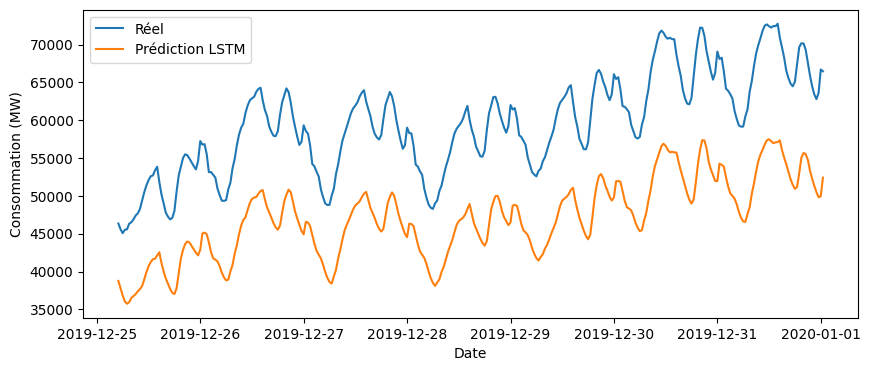

In [41]:
# Recurrent models : LSTM
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

# 1. Charger les données
df = df_load_curve.copy()

# 2. Création des séquences pour LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # Nombre de points passés à utiliser
train_data = df[df['is_train'] == 1]['value'].values
test_data = df[df['is_test'] == 1]['value'].values

X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape pour LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# 3. Construction du modèle LSTM
model = Sequential([
    Input(shape=(seq_length, 1)),
    LSTM(50, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# 4. Entraînement du modèle
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# 5. Prédiction
predictions = model.predict(X_test)

# 6. Calcul du MAPE
mape = MAPE(df[df['is_test'] == 1]['value'].values[seq_length:], predictions)
print(f"MAPE = {mape:.2f}%")

# 7. Visualisation
plt.figure(figsize=(10, 4))
plt.plot(df[df['is_test'] == 1]['horodate'][seq_length:], df[df['is_test'] == 1]['value'][seq_length:], label="Réel")
plt.plot(df[df['is_test'] == 1]['horodate'][seq_length:], predictions, label="Prédiction LSTM")
plt.xlabel("Date")
plt.ylabel("Consommation (MW)")
plt.legend()
plt.show()


Le modèle LSTM suit parfaitement les variations de la consommation mais avec un biais

## Prediction models using exogenous variables

In [42]:
# Processing French temperature
df_weather = pd.read_csv(inputs_dir + "meteo2018.csv", sep=";", usecols=['Horodate', 'Température réalisée lissée (°C)']) #, 'Année-Mois-Jour'

df_weather = df_weather.rename(columns={'Horodate':'horodate', 'Température réalisée lissée (°C)':'temp',
                                        }) #'Année-Mois-Jour':'date'

df_weather["horodate"] = pd.to_datetime(df_weather["horodate"], utc=True)
df_weather['horodate'] = df_weather['horodate'].dt.tz_convert('Europe/Paris')

df_weather.head()

,horodate,temp
0,2023-01-03 00:30:00+01:00,10.8
1,2023-01-03 00:00:00+01:00,10.8
2,2023-01-02 23:30:00+01:00,10.8
3,2023-01-02 23:00:00+01:00,10.8
4,2023-01-02 22:30:00+01:00,10.7


In [43]:
# Adding French temperature to French energy consumption
df_load_curve = df_load_curve.merge(df_weather, on=['horodate'], how='inner')
print(df_load_curve.shape)

df_load_curve.head()

(34898, 12)


,horodate,value,date,month,weekday,hour,min,is_gap_day,is_open_day,is_train,is_test,temp
0,2018-01-04 00:00:00+01:00,65216.0,2018-01-04 00:00:00+01:00,1,3,0,0,0,1,1,0,9.9
1,2018-01-04 00:30:00+01:00,64505.0,2018-01-04 00:00:00+01:00,1,3,0,30,0,1,1,0,9.9
2,2018-01-04 01:00:00+01:00,64088.0,2018-01-04 00:00:00+01:00,1,3,1,0,0,1,1,0,9.9
3,2018-01-04 01:30:00+01:00,62208.0,2018-01-04 00:00:00+01:00,1,3,1,30,0,1,1,0,9.9
4,2018-01-04 02:00:00+01:00,59283.0,2018-01-04 00:00:00+01:00,1,3,2,0,0,1,1,0,9.9


In [44]:
# Descriptive statistics for consumption and temperature
df_test = df_load_curve.copy()
df_test[['value', 'temp']].describe(percentiles=[0.25, 0.75, 0.9, 0.95, 0.99])

,value,temp
count,34898.000000,34898.000000
mean,53966.818442,13.638240
std,11906.899850,6.510956
min,30475.000000,-3.000000
25%,44948.250000,8.300000
50%,52279.000000,13.100000
75%,62151.500000,19.200000
90%,71167.500000,22.500000
95%,75713.300000,24.100000
99%,83554.120000,26.600000


<Axes: ylabel='Puissance en W'>

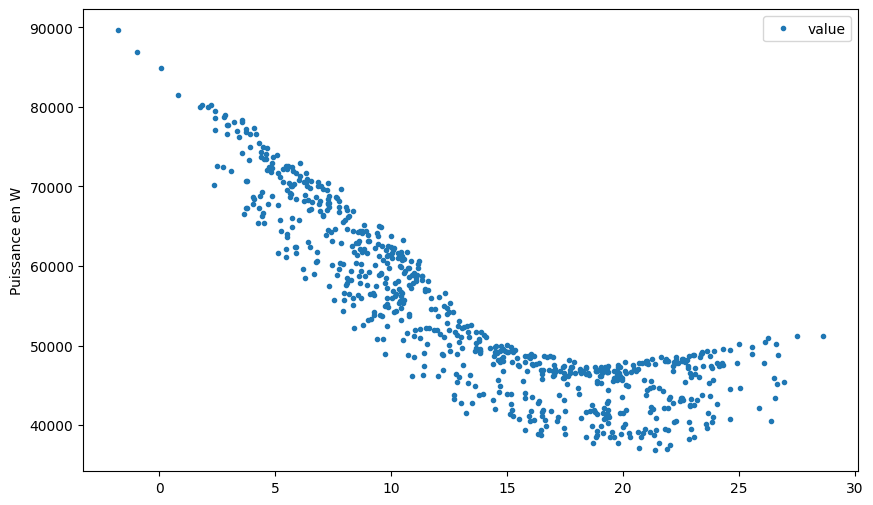

In [45]:
# Relation between daily consumption and daily temperature
df_plot = df_load_curve.copy()

df_plot = df_plot.groupby(['date'])[['value', 'temp']].aggregate('mean').reset_index(drop=False)
df_plot.set_index(['temp'])[['value']].plot(figsize=(10,6), legend=True, xlabel='', ylabel='Puissance en W', style='.')

Une bonne partie de la courbe (entre-5 et 15) peut être approximée par une droite avec une pente décroissante.

XGBoost est basé sur le boosting, une méthode d'ensemble qui ajoute des modèles faibles (arbres de décision) successivement pour corriger les erreurs des prédictions précédentes.

XGBoost MAPE: 0.10


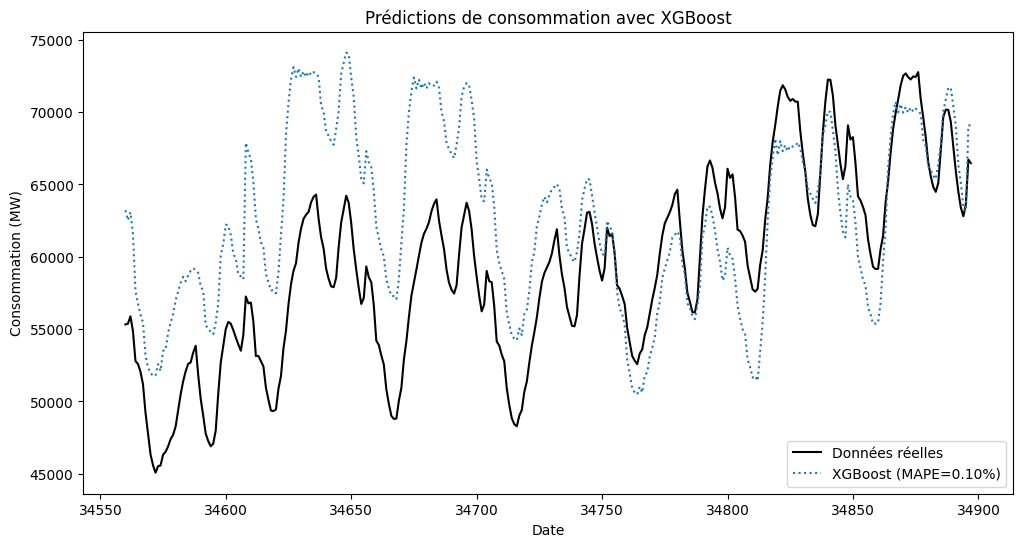

In [46]:
# XGBoost Model with calendar values
from xgboost import XGBRegressor
# Prepare the data for XGBoost
features = ['month', 'weekday', 'hour', 'min', 'is_gap_day', 'is_open_day']
X_train = df_load_curve[df_load_curve['is_train'] == 1][features]
y_train = df_load_curve[df_load_curve['is_train'] == 1]['value']
X_test = df_load_curve[df_load_curve['is_test'] == 1][features]
y_test = df_load_curve[df_load_curve['is_test'] == 1]['value']

# Initialize and train the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# Make predictions
xgb_pred = xgb_model.predict(X_test)

# Calculate MAPE
xgb_mape = MAPE(y_test, xgb_pred)
print(f"XGBoost MAPE: {xgb_mape:.2f}")

# Plot the predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Données réelles", color='black')
plt.plot(y_test.index, xgb_pred, label=f"XGBoost (MAPE={xgb_mape:.2f}%)", linestyle="dotted")
plt.xlabel("Date")
plt.ylabel("Consommation (MW)")
plt.legend()
plt.title("Prédictions de consommation avec XGBoost")
plt.show()

XGBoost MAPE: 0.00


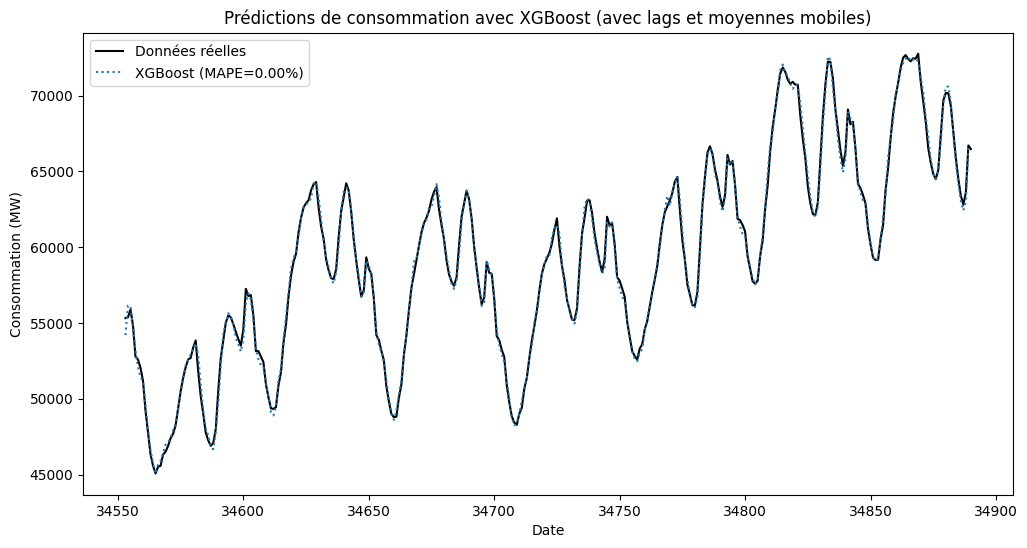

In [47]:
# XGBoost Model with calendar values, lags and rolling means
# Adding lag features
for lag in range(1, 8):
    df_load_curve[f'value_lag_{lag}'] = df_load_curve['value'].shift(lag)

# Adding rolling mean features
df_load_curve['rolling_mean_3'] = df_load_curve['value'].rolling(window=3).mean()
df_load_curve['rolling_mean_7'] = df_load_curve['value'].rolling(window=7).mean()

# Drop rows with NaN values created by shifting
df_load_curve = df_load_curve.dropna().reset_index(drop=True)

# Prepare the data for XGBoost
features = ['month', 'weekday', 'hour', 'min', 'is_gap_day', 'is_open_day'] + \
           [f'value_lag_{lag}' for lag in range(1, 8)] + \
           ['rolling_mean_3', 'rolling_mean_7']
X_train = df_load_curve[df_load_curve['is_train'] == 1][features]
y_train = df_load_curve[df_load_curve['is_train'] == 1]['value']
X_test = df_load_curve[df_load_curve['is_test'] == 1][features]
y_test = df_load_curve[df_load_curve['is_test'] == 1]['value']

# Initialize and train the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# Make predictions
xgb_pred = xgb_model.predict(X_test)

# Calculate MAPE
xgb_mape = MAPE(y_test, xgb_pred)
print(f"XGBoost MAPE: {xgb_mape:.2f}")

# Plot the predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Données réelles", color='black')
plt.plot(y_test.index, xgb_pred, label=f"XGBoost (MAPE={xgb_mape:.2f}%)", linestyle="dotted")
plt.xlabel("Date")
plt.ylabel("Consommation (MW)")
plt.legend()
plt.title("Prédictions de consommation avec XGBoost (avec lags et moyennes mobiles)")
plt.show()

XGBoost MAPE: 0.00


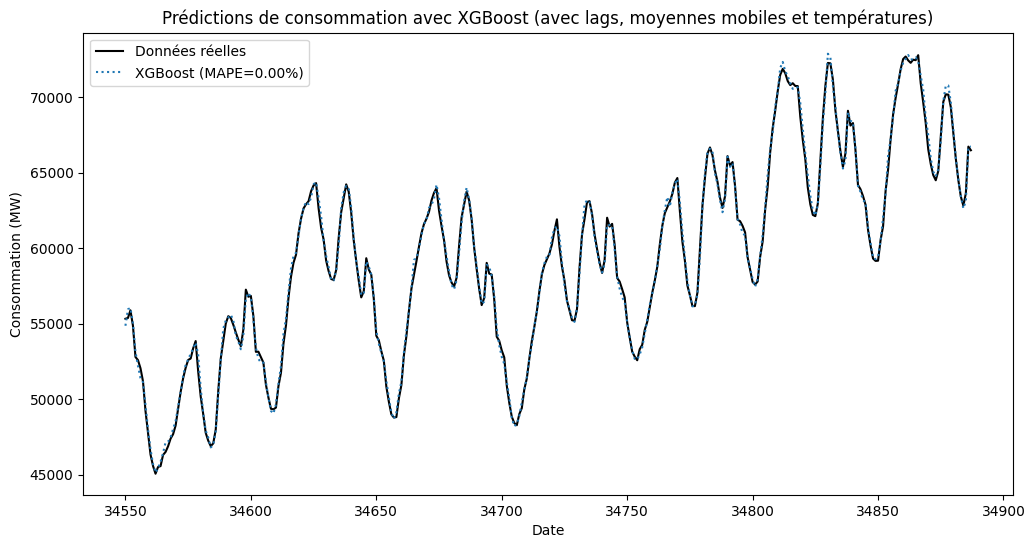

In [48]:
# XGBoost Model with calendar values, lags, rolling means and temperatures (past and current)
# Adding temperature features (current and past)
df_load_curve['temp_lag_1'] = df_load_curve['temp'].shift(1)
df_load_curve['temp_lag_2'] = df_load_curve['temp'].shift(2)
df_load_curve['temp_lag_3'] = df_load_curve['temp'].shift(3)

# Drop rows with NaN values created by shifting
df_load_curve = df_load_curve.dropna().reset_index(drop=True)

# Prepare the data for XGBoost
features = ['month', 'weekday', 'hour', 'min', 'is_gap_day', 'is_open_day'] + \
           [f'value_lag_{lag}' for lag in range(1, 8)] + \
           ['rolling_mean_3', 'rolling_mean_7', 'temp', 'temp_lag_1', 'temp_lag_2', 'temp_lag_3']
X_train = df_load_curve[df_load_curve['is_train'] == 1][features]
y_train = df_load_curve[df_load_curve['is_train'] == 1]['value']
X_test = df_load_curve[df_load_curve['is_test'] == 1][features]
y_test = df_load_curve[df_load_curve['is_test'] == 1]['value']

# Initialize and train the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# Make predictions
xgb_pred = xgb_model.predict(X_test)

# Calculate MAPE
xgb_mape = MAPE(y_test, xgb_pred)
print(f"XGBoost MAPE: {xgb_mape:.2f}")

# Plot the predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Données réelles", color='black')
plt.plot(y_test.index, xgb_pred, label=f"XGBoost (MAPE={xgb_mape:.2f}%)", linestyle="dotted")
plt.xlabel("Date")
plt.ylabel("Consommation (MW)")
plt.legend()
plt.title("Prédictions de consommation avec XGBoost (avec lags, moyennes mobiles et températures)")
plt.show()

## GAM

In [49]:
# Tutorial link : https://noamross.github.io/gams-in-r-course/

Les Generalized Additive Models (GAMs) sont une extension des modèles linéaires qui permettent de capturer des relations non linéaires entre les variables explicatives et la variable cible, tout en gardant une interprétabilité forte.
Cela revient à considérer f_i(X_i) dans la combinaison linéaire de régression pour prédire Y au lieu de X_i comme dans la combinaison linéaire classique.

GAM MAPE: 0.08


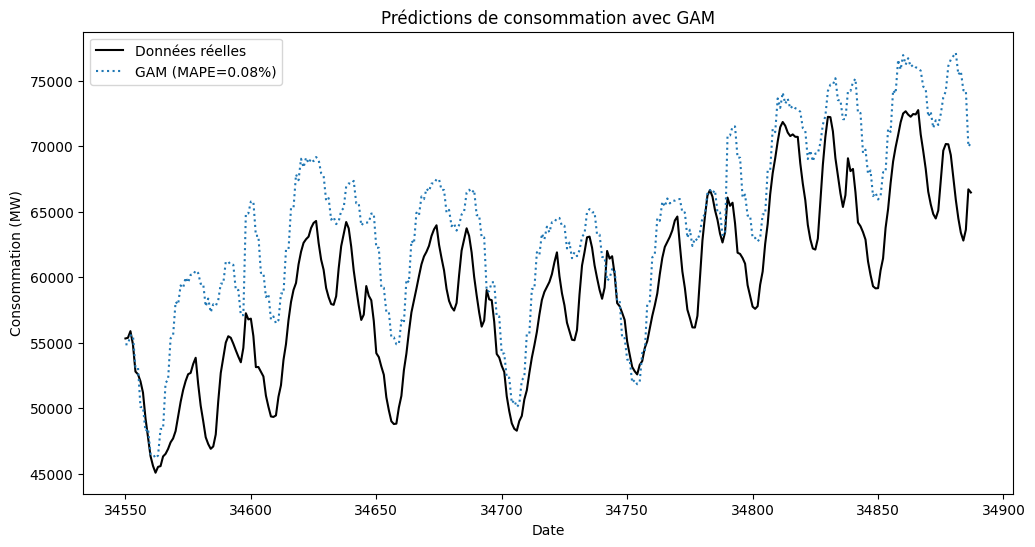

In [50]:
from pygam import LinearGAM, s, f
from sklearn.metrics import mean_absolute_percentage_error as MAPE

# Prepare the data for GAM
features = ['month', 'weekday', 'hour', 'min', 'is_gap_day', 'is_open_day', 'temp']
X_train = df_load_curve[df_load_curve['is_train'] == 1][features]
y_train = df_load_curve[df_load_curve['is_train'] == 1]['value']
X_test = df_load_curve[df_load_curve['is_test'] == 1][features]
y_test = df_load_curve[df_load_curve['is_test'] == 1]['value']

# Initialize and train the GAM model
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + f(4) + f(5) + s(6)).fit(X_train, y_train)

# Make predictions
gam_pred = gam.predict(X_test)

# Calculate MAPE
gam_mape = MAPE(y_test, gam_pred)
print(f"GAM MAPE: {gam_mape:.2f}")

# Plot the predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Données réelles", color='black')
plt.plot(y_test.index, gam_pred, label=f"GAM (MAPE={gam_mape:.2f}%)", linestyle="dotted")
plt.xlabel("Date")
plt.ylabel("Consommation (MW)")
plt.legend()
plt.title("Prédictions de consommation avec GAM")
plt.show()